In [1]:
!pip install bitsandbytes transformers accelerate vllm

In [2]:
import pprint
import torch
from torch.distributions import Categorical
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig, set_seed, BitsAndBytesConfig

# Default device is CPU
device = torch.device('cpu')

# Check if CUDA GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA GPU is available')
    print(f"Device name: {torch.cuda.get_device_name(0)}")


target_model_name = "unsloth/Llama-3.2-3B-Instruct-bnb-4bit"
auxilary_model_name = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit"

# Load models and tokenizer
compute_dtype = torch.bfloat16
quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        llm_int8_threshold=6.0,
        llm_int8_has_fp16_weight=False,
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
)

model_args = {"torch_dtype": compute_dtype, "device_map": "auto"}
target_model = AutoModelForCausalLM.from_pretrained(target_model_name, **model_args)
auxilary_model = AutoModelForCausalLM.from_pretrained(auxilary_model_name, **model_args)
tokenizer = AutoTokenizer.from_pretrained(target_model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

CUDA GPU is available
Device name: NVIDIA GeForce RTX 4090


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


In [3]:
@torch.no_grad()
def sample_decode(model, tokenizer, input_ids: torch.Tensor, max_new_tokens: int, temperature: float = 1.0) -> torch.Tensor:
    log_zero = -1e4

    # Initialize generated tokens with the input prompt
    generated_ids = input_ids
    finished_sequences = torch.zeros(input_ids.shape[0], dtype=torch.bool, device=model.device)
    log_probs = []

    # Iteratively generate tokens using greedy decoding
    for token_idx in range(max_new_tokens):
        # Filter out finished sequences
        active_indices = torch.nonzero(~finished_sequences).squeeze(-1)
        if len(active_indices) == 0:
            break

        # Get model outputs for active sequences
        active_input_ids = generated_ids[active_indices]
        outputs = model(input_ids=active_input_ids)
        logits = outputs.logits

        # Get the last token logits and apply argmax to select the next token
        next_token_logits = logits[:, -1, :] / temperature
        next_token_log_probs = torch.nn.functional.log_softmax(next_token_logits, dim=-1)
        next_token_id = Categorical(logits=next_token_log_probs).sample()
        # next_token_log_prob, next_token_id = next_token_log_probs.max(dim=-1)

        # Save log next-token distribution for each sequence in batch; inactivate sequences produce <pad> token with probability 1
        curr_log_probs = torch.full((input_ids.shape[0], len(tokenizer)), log_zero, dtype=next_token_log_probs.dtype, device=model.device)
        curr_log_probs[:, tokenizer.pad_token_id] = 0.0
        curr_log_probs[active_indices] = next_token_log_probs
        log_probs.append(curr_log_probs)

        # Update finished sequences and add padding if necessary
        finished_sequences[active_indices] |= (next_token_id == tokenizer.eos_token_id)

        # Create a tensor for the next tokens to append to all sequences
        new_tokens = torch.full((generated_ids.shape[0], 1), tokenizer.pad_token_id, dtype=torch.long, device=model.device)
        new_tokens[active_indices] = next_token_id.unsqueeze(-1)

        # Append the next token to the generated sequence
        generated_ids = torch.cat([generated_ids, new_tokens], dim=-1)

    return generated_ids, log_probs

In [4]:
@torch.no_grad()
def specualative_decode(target_model, auxilary_model, tokenizer, input_ids: torch.Tensor,
                        max_new_tokens: int, num_speculated: int = 5, temperature: float = 1.0) -> torch.Tensor:
    # Initialize generated tokens with the input prompt
    generated_ids = input_ids
    max_length = input_ids.shape[1] + max_new_tokens

    while generated_ids.shape[1] < max_length:
        tokens_remaining = max_length - generated_ids.shape[1]
        speculation_size = min(num_speculated, tokens_remaining - 1)

        if speculation_size > 0:

            # Generate speculative tokens
            speculated_ids, speculated_log_probs = sample_decode(auxilary_model, tokenizer, generated_ids, speculation_size, temperature)
            speculation_size = speculated_ids.shape[1] - generated_ids.shape[1]
            speculated_token_ids = speculated_ids[:, -speculation_size:]
            speculated_log_probs = torch.stack(speculated_log_probs, dim=1).squeeze(0)

            # Verify all speculative tokens in one forward pass
            outputs = target_model(input_ids=speculated_ids)
            target_logits = outputs.logits[:, -(speculation_size + 1):, :].squeeze(0) / temperature
            target_log_probs = torch.nn.functional.log_softmax(target_logits, dim=-1)

            # Compare log-likelihood ratios of target and speculative tokens; use unifrorm (0, 1) distribution to decide acceptance
            log_likelihood_ratios = target_log_probs[:-1].gather(1, speculated_token_ids.view(-1,1)) \
                                    - speculated_log_probs.gather(1, speculated_token_ids.view(-1,1))
            uniform_log_probs = torch.log(torch.rand_like(log_likelihood_ratios))
            rejected_indexes = torch.nonzero((log_likelihood_ratios <= uniform_log_probs).squeeze(-1))

            if len(rejected_indexes) > 0:
                # Some speculative tokens are rejected, truncate the accepted tokens
                rejected_token_idx = rejected_indexes[0]
                accepted_ids = speculated_token_ids[:, :rejected_token_idx]

                # Sample the next token from the adjusted distribution
                adjusted_distribution = torch.clamp(
                    torch.exp(target_log_probs[rejected_token_idx]) - torch.exp(speculated_log_probs[rejected_token_idx]),
                    min=0
                )
                adjusted_distribution = torch.div(adjusted_distribution, adjusted_distribution.sum())
                next_token_id = Categorical(probs=adjusted_distribution).sample()

            else:
                # All speculative tokens are accepted, sample the next token from target model
                accepted_ids = speculated_token_ids
                if accepted_ids[0, -1].item() != tokenizer.eos_token_id:
                    next_token_id = Categorical(logits=target_logits[[-1]]).sample()

            # Append the accepted tokens to the generated sequence
            if accepted_ids.numel() == 0 or (accepted_ids.numel() > 0  and accepted_ids[0, -1].item() != tokenizer.eos_token_id):
                new_tokens = torch.cat([accepted_ids, next_token_id.unsqueeze(-1)], dim=-1)
            else:
                new_tokens = accepted_ids

            generated_ids = torch.cat([generated_ids, new_tokens], dim=-1)

        else:
            # If no speculation is performed, use the target model for generation
            outputs = target_model(input_ids=generated_ids)
            target_logits = outputs.logits[:, -1, :].squeeze(0) / temperature
            target_log_probs = torch.nn.functional.log_softmax(target_logits, dim=-1).unsqueeze(0)
            next_token_id = Categorical(logits=target_log_probs).sample()
            generated_ids = torch.cat([generated_ids, next_token_id.unsqueeze(0)], dim=-1)

        if generated_ids[0, -1] == tokenizer.eos_token_id:
            break

    return generated_ids

In [5]:
messages = [
    [
        {'role': 'system', 'content': 'You are an algebra assistant. The user will ask you math questions and you will solve them.'},
        {'role': 'user', 'content': "Peter purchased 20 popsicles at $0.25 each. He also purchased 2730244 ice cream bars at $0.50 each. How much did he pay in total in dollars?"},
    ],
]
max_new_tokens = 120
temperature = 0.001

inputs = tokenizer.apply_chat_template(messages)
for input_ids, message in zip(inputs, messages):
    input_ids = torch.tensor(input_ids, device=target_model.device).unsqueeze(0)

    set_seed(42)
    speculative_ids = specualative_decode(target_model, auxilary_model, tokenizer, input_ids, max_new_tokens, temperature=temperature)

    set_seed(42)
    sampled_ids, log_probs = sample_decode(target_model, tokenizer, input_ids, max_new_tokens, temperature=temperature)

    if torch.equal(speculative_ids, sampled_ids):
        print("The outputs match!")
    else:
        print("The outputs do not match.")

    speculative_text = tokenizer.batch_decode(speculative_ids, skip_special_tokens=True)
    sampled_text = tokenizer.batch_decode(sampled_ids, skip_special_tokens=True)

    pprint.pprint({"Prompt": message, "Speculative": speculative_text, "Sampled": sampled_text})


The outputs match!
{'Prompt': [{'content': 'You are an algebra assistant. The user will ask you '
                        'math questions and you will solve them.',
             'role': 'system'},
            {'content': 'Peter purchased 20 popsicles at $0.25 each. He also '
                        'purchased 2730244 ice cream bars at $0.50 each. How '
                        'much did he pay in total in dollars?',
             'role': 'user'}],
 'Sampled': ['system\n'
             '\n'
             'Cutting Knowledge Date: December 2023\n'
             'Today Date: 12 Nov 2024\n'
             '\n'
             'You are an algebra assistant. The user will ask you math '
             'questions and you will solve them.user\n'
             '\n'
             'Peter purchased 20 popsicles at $0.25 each. He also purchased '
             '2730244 ice cream bars at $0.50 each. How much did he pay in '
             'total in dollars?assistant\n'
             '\n'
             'To find the tota

In [6]:
from datasets import load_dataset
from tqdm.notebook import tqdm
from collections import defaultdict
import time

seed = 42
temperature = 0.1
max_new_tokens = 10
target_device = target_model.device
data = load_dataset("reasoning-machines/gsm-hard")['train'].shuffle(seed=seed).select(range(10))['input']
messages = [
    [
        {'role': 'system', 'content': 'You are an algebra assistant. The user will ask you math questions and you will solve them.'},
        {'role': 'user', 'content': example},
    ]
    for example in data
]
inputs = tokenizer.apply_chat_template(messages, tokenize=False)

In [7]:
from accelerate.utils import release_memory

sample_latencies = []
for example in tqdm(inputs):
    input_ids = tokenizer(example, return_tensors="pt", padding=False).input_ids.to(target_device)
    start = time.time()
    sampled_ids, log_probs = sample_decode(target_model, tokenizer, input_ids, max_new_tokens, temperature=temperature)
    latency = time.time() - start
    sample_latencies.append(latency)

target_model = release_memory(target_model)
auxilary_model = release_memory(auxilary_model)

  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
import torch
import gc
import os
os.environ["VLLM_LOGGING_LEVEL"] = "ERROR"

from vllm import LLM, SamplingParams

sampling_params = SamplingParams(temperature=temperature, seed=seed, max_tokens=max_new_tokens)
vllm_args = {
    "model": target_model_name,
    "tensor_parallel_size": 1,
    "max_model_len": 4096,
    "speculative_model": auxilary_model_name,
    "use_v2_block_manager": True,
    "trust_remote_code": True,
    "gpu_memory_utilization": 0.8,
    "dtype": torch.bfloat16,
    "quantization": "bitsandbytes",
    "load_format": "bitsandbytes"
}

vllm_latencies = defaultdict(list)
for specualtion_size in range(1, 20):
    print(f"Testing with {specualtion_size} speculative tokens")
    llm = LLM(num_speculative_tokens=specualtion_size, **vllm_args)
    speculative_latencies = []
    for example in tqdm(inputs):
        input_ids = tokenizer(example, padding=False)
        start = time.time()
        outputs = llm.generate(input_ids, sampling_params=sampling_params)
        latency = time.time() - start
        speculative_latencies.append(latency)
    vllm_latencies[specualtion_size] = speculative_latencies
    del llm
    torch.cuda.empty_cache()
    gc.collect()

Testing with 1 speculative tokens


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s, est. speed input: 27.70 toks/s, output: 92.31 toks/s]


Testing with 2 speculative tokens


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s, est. speed input: 30.09 toks/s, output: 100.29 toks/s]


Testing with 3 speculative tokens


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  8.34it/s, est. speed input: 25.06 toks/s, output: 83.52 toks/s]


Testing with 4 speculative tokens


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  9.03it/s, est. speed input: 27.09 toks/s, output: 90.31 toks/s]


Testing with 5 speculative tokens


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s, est. speed input: 20.49 toks/s, output: 68.29 toks/s]


Testing with 6 speculative tokens


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s, est. speed input: 20.30 toks/s, output: 67.67 toks/s]


Testing with 7 speculative tokens


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  8.22it/s, est. speed input: 24.67 toks/s, output: 82.21 toks/s]


Testing with 8 speculative tokens


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  8.35it/s, est. speed input: 25.18 toks/s, output: 83.93 toks/s]


Testing with 9 speculative tokens


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  5.41it/s, est. speed input: 16.25 toks/s, output: 54.18 toks/s]


Testing with 10 speculative tokens


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s, est. speed input: 19.75 toks/s, output: 65.84 toks/s]


Testing with 11 speculative tokens


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  6.42it/s, est. speed input: 19.33 toks/s, output: 64.43 toks/s]


Testing with 12 speculative tokens


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  6.47it/s, est. speed input: 19.48 toks/s, output: 64.93 toks/s]


Testing with 13 speculative tokens


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  4.11it/s, est. speed input: 12.37 toks/s, output: 41.23 toks/s]


Testing with 14 speculative tokens


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  2.72it/s, est. speed input: 8.18 toks/s, output: 27.25 toks/s]


Testing with 15 speculative tokens


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  5.56it/s, est. speed input: 16.69 toks/s, output: 55.62 toks/s]


Testing with 16 speculative tokens


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  4.47it/s, est. speed input: 13.43 toks/s, output: 44.77 toks/s]


Testing with 17 speculative tokens


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  4.25it/s, est. speed input: 12.75 toks/s, output: 42.50 toks/s]


Testing with 18 speculative tokens


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  2.43it/s, est. speed input: 7.30 toks/s, output: 24.33 toks/s]


Testing with 19 speculative tokens


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  2.51it/s, est. speed input: 7.52 toks/s, output: 25.08 toks/s]


<BarContainer object of 19 artists>

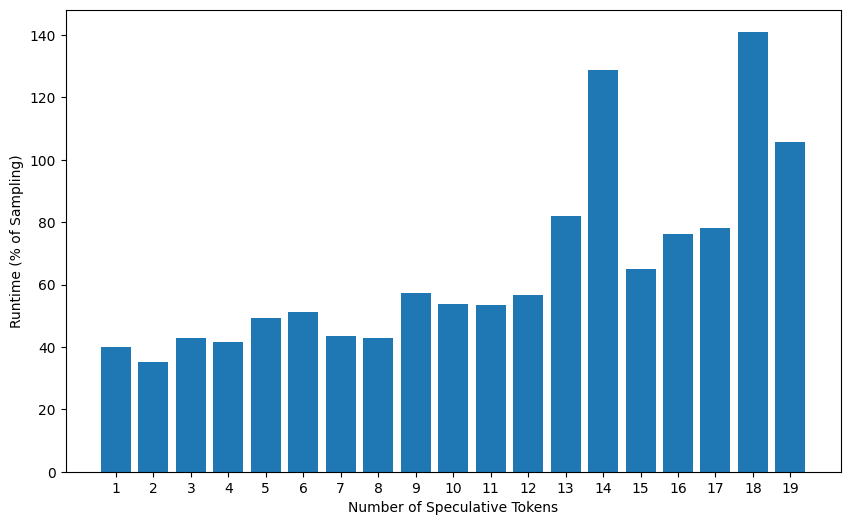

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sample_latencies_mean = np.mean(sample_latencies)
vllm_latencies_df = pd.DataFrame(vllm_latencies)
improvements = vllm_latencies_df.mean(axis=0) / sample_latencies_mean

plt.figure(figsize=(10, 6))
plt.ylabel("Runtime (% of Sampling)")
plt.xlabel("Number of Speculative Tokens")
plt.xticks(vllm_latencies_df.columns)
plt.bar(vllm_latencies_df.columns, improvements * 100)

